In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Gordon


In [8]:
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed, binary_dilation, disk
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.measure import regionprops, label
from sklearn.cluster import KMeans
from skimage.transform import rotate, resize

from annotation_utilities import *
from registration_utilities import *

In [3]:
stack = 'MD589'

In [25]:
min_blob_area = 40
max_blob_area = 10000

In [26]:
output_dir = create_if_not_exists('/home/yuncong/csd395/CSHL_cells_v2/detected_cells/' + stack)

In [27]:
filename_to_section, section_to_filename = DataManager.load_sorted_filenames(stack)
first_bs_section, last_bs_section = DataManager.load_cropbox(stack)[4:]

Processing section: 092
Load image: 104.53
Load mask: 9.53
threshold: 2.87
distance transform: 25.64
local max: 15.96
label: 8.01
watershed: 49.25
regionprops: 2.89


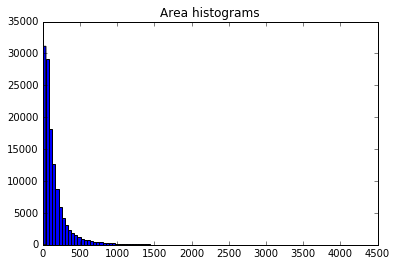

97725 blobs identified.
Compute blob properties, save: 142.21
Save image: 17.83
Processing section: 142
Load image: 120.52
Load mask: 9.55
threshold: 2.67
distance transform: 25.29
local max: 16.31
label: 8.12
watershed: 41.49
regionprops: 3.63


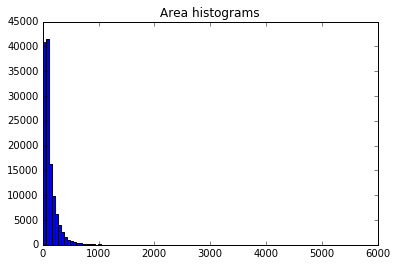

96259 blobs identified.
Compute blob properties, save: 125.91
Save image: 17.81
Processing section: 192
Load image: 122.39
Load mask: 9.53
threshold: 2.67
distance transform: 25.42
local max: 16.18
label: 7.95
watershed: 59.33
regionprops: 3.88


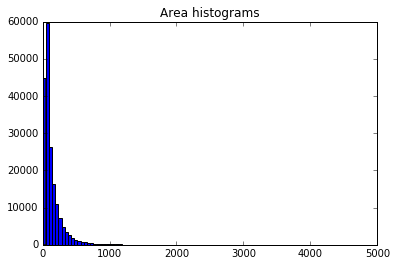

148148 blobs identified.
Compute blob properties, save: 192.49
Save image: 20.10
Processing section: 242
Load image: 103.22
Load mask: 9.53
threshold: 2.47
distance transform: 25.72
local max: 16.22
label: 7.96
watershed: 39.26
regionprops: 3.63


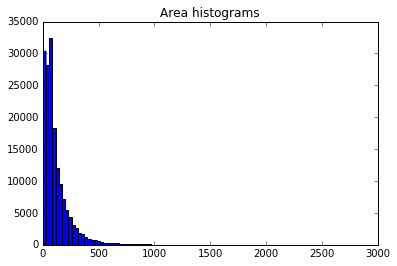

124902 blobs identified.
Compute blob properties, save: 163.28
Save image: 18.47
Processing section: 292
Load image: 100.72
Load mask: 9.54
threshold: 3.00
distance transform: 24.71
local max: 15.79
label: 7.96
watershed: 42.63
regionprops: 4.59


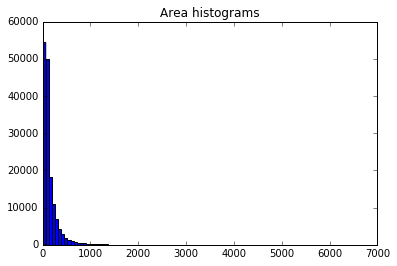

122498 blobs identified.
Compute blob properties, save: 166.63
Save image: 15.98
Processing section: 342
Load image: 105.64
Load mask: 9.56
threshold: 2.72
distance transform: 24.71
local max: 15.73
label: 7.97
watershed: 42.43
regionprops: 3.33


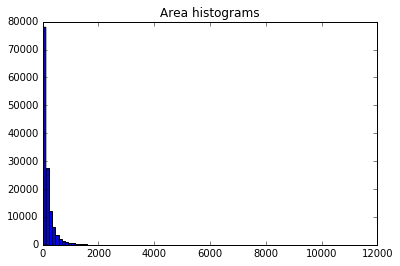

99596 blobs identified.
Compute blob properties, save: 153.23
Save image: 20.37


In [28]:
bar = show_progress_bar(first_bs_section, last_bs_section)

# for sec in [first_bs_section]:
for sec in range(first_bs_section, last_bs_section, 50):
    
    fn = section_to_filename[sec]

    bar.value = sec

    sys.stderr.write('Processing section: %03d\n' % sec)
    
    t = time.time()

    img = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='rgb'))
    im = rgb2gray(img)

    sys.stderr.write('Load image: %.2f\n' % (time.time() - t) )
    
    t = time.time()
    
    mask_tb = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec)
    mask = resize(mask_tb, img.shape[:2]) > .5
    
    sys.stderr.write('Load mask: %.2f\n' % (time.time() - t) )
    
    t = time.time()

    thresh = threshold_otsu(im)
    binary = im < thresh
    binary[~mask] = 0

    sys.stderr.write('threshold: %.2f\n' % (time.time() - t) )

    # plt.imshow(binary, cmap=plt.cm.gray);
    # plt.axis('off');
    # plt.title('binary');

    t = time.time()
    dt = distance_transform_edt(binary)
    sys.stderr.write('distance transform: %.2f\n' % (time.time() - t) )

    # plt.imshow(dt, cmap=plt.cm.gray);
    # plt.axis('off');
    # plt.title('distance tranform');

    t = time.time()
    local_maxi = peak_local_max(dt, labels=binary, footprint=np.ones((10, 10)), indices=False)
    sys.stderr.write('local max: %.2f\n' % (time.time() - t) )

    # plt.imshow(local_maxi, cmap=plt.cm.gray);
    # plt.axis('off');
    # plt.title('local maxima');

    t = time.time()
    markers = label(local_maxi)
    sys.stderr.write('label: %.2f\n' % (time.time() - t) )

    t = time.time()
    labels = watershed(-dt, markers, mask=binary)
    sys.stderr.write('watershed: %.2f\n' % (time.time() - t) )

    # plt.imshow(labels);
    # plt.axis('off');
    # plt.title('labels');

    t = time.time()
    props = regionprops(labels)
    sys.stderr.write('regionprops: %.2f\n' % (time.time() - t) )

    plt.hist([p.area for p in props], bins=100);
    plt.title('Area histograms');
    plt.show();
    
    valid_blob_indices = [i for i, p in enumerate(props) if p.area > min_blob_area and p.area < max_blob_area]
    sys.stderr.write('%d blobs identified.\n' % len(valid_blob_indices))

    fn_output_dir = create_if_not_exists(os.path.join(output_dir, fn))

    t = time.time()

    valid_blob_coords = [props[i].coords for i in valid_blob_indices] # r,c
    valid_blob_orientations = np.array([props[i].orientation for i in valid_blob_indices])
    valid_blob_centroids = np.array([props[i].centroid for i in valid_blob_indices]) # r,c
    valid_blob_majorAxisLen = np.array([props[i].major_axis_length for i in valid_blob_indices])
    valid_blob_minorAxisLen = np.array([props[i].minor_axis_length for i in valid_blob_indices])
    
#     valid_blob_bbox = [np.array(props[i].bbox) for i in valid_blob_indices]
    blob_contours = find_contour_points(labels, sample_every=1)
    valid_blob_contours = [blob_contours[i+1][0] for i in valid_blob_indices]
#     valid_blob_contours = [cnts[0] for i, cnts in enumerate(valid_blob_contours)]

    pickle.dump(valid_blob_contours, open(fn_output_dir + '/%(fn)s_blobContours.pkl' % {'fn':fn}, 'w'))
    
    pickle.dump(valid_blob_coords, open(fn_output_dir + '/%(fn)s_blobCoords.pkl' % {'fn':fn}, 'w'))
    bp.pack_ndarray_file(valid_blob_orientations, fn_output_dir + '/%(fn)s_blobOrientations.bp' % {'fn':fn})
    bp.pack_ndarray_file(valid_blob_centroids, fn_output_dir + '/%(fn)s_blobCentroids.bp' % {'fn':fn})
    bp.pack_ndarray_file(valid_blob_majorAxisLen, fn_output_dir + '/%(fn)s_blobMajorAxisLen.bp' % {'fn':fn})
    bp.pack_ndarray_file(valid_blob_minorAxisLen, fn_output_dir + '/%(fn)s_blobMinorAxisLen.bp' % {'fn':fn})

    sys.stderr.write('Compute blob properties, save: %.2f\n' % (time.time() - t) )
    
    
    t = time.time()

    h, w = img.shape[:2]
    for cnt in valid_blob_contours:
        img[np.minimum(h-1, np.maximum(cnt[:,1], 0)), np.minimum(w-1, np.maximum(cnt[:,0], 0))] = (255,0,0)

    imsave('/home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD589/%(fn)s/%(fn)s_detection_image.jpg' % {'fn':fn}, img)
    
    sys.stderr.write('Save image: %.2f\n' % (time.time() - t) )